In [ ]:
# Activate your environment
import Pkg
Pkg.activate("Env")

In [10]:
using UnfoldSim
using Unfold
using Random
using DSP
using CairoMakie, UnfoldMakie
using DataFrames
using StableRNGs
using SequentialSamplingModels
using Statistics

## Components

In [11]:
struct DriftComponent <: AbstractComponent
    basis::Any
    time_vec::Any
    Δt::Any
    model_type::Any #Type{AbstractDDM}
    model_parameters::Dict
end

get_model_parameter(rng, evt, val::String) = evt[val]
get_model_parameter(rng, evt, val) = val
function get_model_parameter(rng, evt, d::Dict)
    result_parameter = Dict()
    for key in keys(d)
        result_parameter[key] = get_model_parameter(rng, evt, d[key])
    end
    return result_parameter
end

Base.length(c::DriftComponent) = length(c.time_vec)

### Simulation Functions

In [12]:
function UnfoldSim.simulate_component(rng, component::DriftComponent, design::AbstractDesign)
    rts, traces = trace_sequential_sampling_model(deepcopy(rng), component, design)
    return traces
end

In [13]:
function calculate_response_times_for_ssm(rng, component::DriftComponent, design::UnfoldSim.SubselectDesign)
    rts, traces = trace_sequential_sampling_model(deepcopy(rng), component, design)
    return rts
end

calculate_response_times_for_ssm (generic function with 1 method)

In [14]:
function trace_sequential_sampling_model(rng, component::DriftComponent, design::AbstractDesign)
    events = generate_events(rng, design)
    traces = Matrix{Float64}(undef, length(component.time_vec), size(events, 1))
    rts = Vector{Float64}(undef, size(events, 1))
    for (i, evt) in enumerate(eachrow(events))
        parameters = get_model_parameter(rng, evt, component.model_parameters)
        model = component.model_type(; (key => parameters[key] for key in keys(parameters))...)
        rt, evidence = SSM_Simulate(rng, model, component.Δt, component.time_vec)

        rts[i] = rt
        traces[:, i] = evidence[1:length(component.time_vec)]
    end
    return rts, traces 
end

trace_sequential_sampling_model (generic function with 1 method)

## Models and their Simulation

### Kelly Model

In [15]:
"""
    KellyModel

A advanced drift diffusion Model which can be used to simulate evidence accumulation.

All fields can be named. Is used with [`DriftComponent`](@ref).

# Fields T::Real
- `drift_rate::T`: defines the amount of evidence accumulated per time step. (steepness of the trace)
- `event_onset::T`: event onset delay in seconds. (mimics sensory evidence)
- `sensor_encoding_delay::T`: variability in the delay of the event onset in seconds. (mimics sensory encoding delay)
- `accumulative_level_noise::T`: some noise added to the accumulation process.
- `boundary::T`: the threshold of evidence needed to make a decision.
- `motor_onset::T`: fixed delay between boundary reached and response time in seconds. (mimics motor time)
- `motor_delay::T`: variability in delay between boundary reached and response time in seconds. (mimics different reaction times of participants)
- `post_accumulation_duration::T`: fixed time the accumulation process resumes after boundary reached in seconds. (mimics evidence overshoot)
- `post_accumulation_duration_variability::T`: variability in time the accumulation process resumes after boundary reached in seconds. (mimics diff of participants)
- `ramp_down_duration::T`: duration post accumulation process ramp down.

# Examples
```julia-repl
julia> KellyModel();
KellyModel{Float64}(6.0, 0.2, 0.4, 0.5, 1.0, 0.1, 0.4, 0.1, 0.2, 0.1)
```

See also [`LinearModelComponent`](@ref), [`MultichannelComponent`](@ref).
"""
mutable struct KellyModel
    drift_rate::Union{Real,String} # drift rate
    event_onset::Union{Real,String} # onset(sensory evidence)
    sensor_encoding_delay::Union{Real,String} # var(sensory encoding delay)
    accumulative_level_noise::Union{Real,String} # accum level noise
    boundary::Union{Real,String} # boundaryary height
    motor_onset::Union{Real,String} # onset(motor)
    motor_delay::Union{Real,String} # var(motor)
    post_accumulation_duration::Union{Real,String} # mean(post decision)
    post_accumulation_duration_variability::Union{Real,String} # var(post decision)
    ramp_down_duration::Union{Real,String} # CPPrampdown duration

    # Constructor with default values
    function KellyModel(;
        drift_rate = 6.0,
        event_onset = 0.2,
        sensor_encoding_delay = 0.1,
        accumulative_level_noise = 0.5,
        boundary = 1.0,
        motor_onset = 0.4,
        motor_delay = 0.1,
        post_accumulation_duration = 0.1,
        post_accumulation_duration_variability = 0.2,
        ramp_down_duration = 0.1,
    )
        return new(drift_rate, event_onset, sensor_encoding_delay, accumulative_level_noise, boundary, motor_onset,
            motor_delay, post_accumulation_duration, post_accumulation_duration_variability,
            ramp_down_duration)
    end
end

"""
    create_kelly_parameters_dict(model::KellyModel)

Convert a `KellyModel` instance into a dictionary containing its parameters.

# Arguments
- `model::KellyModel`: The Kelly model instance whose parameters will be extracted.

# Returns
- `Dict{Symbol, Any}`: A dictionary where the keys are the parameter names as symbols, and the values are the corresponding parameter values.

# Examples
```julia-repl
julia> model = KellyModel(drift_rate=5.5, boundary=1.2)
KellyModel(5.5, 0.2, 0.4, 0.5, 1.2, 0.1, 0.4, 0.1, 0.2, 0.1)

julia> create_kelly_parameters_dict(model)
Dict{Symbol, Any}(:drift_rate => 5.5, :event_onset => 0.2, :sensor_encoding_delay => 0.4, 
                  :accumulative_level_noise => 0.5, :boundary => 1.2, :motor_onset => 0.1, 
                  :motor_delay => 0.4, :post_accumulation_duration => 0.1, 
                  :post_accumulation_duration_variability => 0.2, :ramp_down_duration => 0.1)
"""
function create_kelly_parameters_dict(model::KellyModel)
    return Dict(name => getfield(model, name) for name in fieldnames(typeof(model)))
end


"""
    KellyModel_simulate_cpp(rng, model::KellyModel, time_vec, Δt)

Generate response time and evidence of an evidence accumulation process using the Kelly model.

# Arguments
- `rng::StableRNG`: Random seed to ensure the same traces are created for reconstruction.
- `model::KellyModel`:  specifies the model and its parameters to simulate the evidence accumulation.
- `time_vec::StepRangeLen`: range of time steps for which the evidence is accumulated.
- `Δt::Float64`: size of the time steps

# Returns
- `Float64`: Simulated response time for this trial.
- `Vector{Float64}`: evidence values over time. The output dimension is `length(time_vec)`.

# Examples
```julia-repl
# use the KellyModel and its default parameters to simulate traces from 0:1/500:1.0
julia> KellyModel_simulate_cpp(StableRNG(1), KellyModel(), 0:1/500:1.0, 1/500)
(260.70134768436486, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
```
"""
function KellyModel_simulate_cpp(rng, model::KellyModel, time_vec, Δt)
    evidence = zeros(length(time_vec));
    evidence[time_vec .>= (model.event_onset+(rand(rng) -.5)*model.sensor_encoding_delay)] .= 1; 
    startAccT = time_vec[findfirst(evidence .== 1)];

    noise = vcat(zeros(
        sum(time_vec .< startAccT)),
        randn(rng,sum(time_vec .>=  startAccT)) .*  model.accumulative_level_noise .*sqrt(Δt));
    ev=evidence;
    ev[time_vec .< startAccT] .= 0; # set to zero all of the evidence before accT
    cum_evidence = cumsum(ev .* model.drift_rate .* Δt .+ noise,dims=1); # This is the cumulative differential evidence, just as in a 1d DDM. 
    
    
    # terminate the decision process on boundary crossing, record threshold-crossing samplepoint:
    cum_evidence = abs.(cum_evidence);
    dti = findfirst(cum_evidence .> model.boundary); # finding the sample point of threshold crossing of each, then will pick the earlier as the winner
    if isnothing(dti)  # Check if no crossing was found
        dti = length(time_vec)  # Set to the last time step
    end
    # now record RT in sec after adding motor time, with variability
    rt = time_vec[dti] + model.motor_onset + (rand(rng) - 0.5) * model.motor_delay

    # now make the CPP peak and go down linearly after a certain amount of post-dec accum time for this trial:
    post_acc_duration = model.post_accumulation_duration .+ model.post_accumulation_duration_variability .* rand(rng);
    # so post_acc_duration is the post accumulation duration time, where the accumulation spikes over the threshold

    # acc_stop_index is the accumulation Stop index which is the index from the time Vector where the accumulation really stops
    acc_stop_index = dti + (post_acc_duration÷Δt)|>Int;
    # Take the absolute value of the accumulations
    cum_evidence = abs.(cum_evidence)
    if acc_stop_index < length(time_vec)
        nT = length(time_vec)
        tmp = cum_evidence[acc_stop_index] .- (1:(nT-acc_stop_index)) .*cum_evidence[acc_stop_index] .* (Δt ./ model.ramp_down_duration)
        cum_evidence[(acc_stop_index+1):end] .= max.(Ref(0), tmp);
    end
    return rt / Δt, cum_evidence[1:end]
end

KellyModel_simulate_cpp (generic function with 1 method)

In [16]:
function SSM_Simulate(rng, model::KellyModel, Δt, time_vec)
    max_steps = length(time_vec)
    rt, evidence = KellyModel_simulate_cpp(rng, model, time_vec, Δt)
    if length(evidence) < max_steps
        final_value = 0
        append!(evidence, fill(final_value, max_steps - length(evidence)))
    end
    evidence = evidence[1:max_steps]
    return rt, evidence
end

function SSM_Simulate(rng, model::LBA, Δt, time_vec)
    max_steps = length(time_vec)
    (; τ, A, k, ν, σ) = model
    b = A + k
    n = length(ν)
    νs = SequentialSamplingModels.sample_drift_rates(rng, ν, σ)
    a = rand(rng,SequentialSamplingModels.Uniform(0, A), n)
    dt = @. (b - a) / νs
    choice, t = SequentialSamplingModels.select_winner(dt)
    evidence = collect.(range.(a, a + νs * t, step = Δt))

    time_steps = range(start=0, step=Δt, length=length(evidence[1]))

    # LBA fix:
    evidence = hcat(evidence...)
    evidence = collect(vec(evidence))

    # Store results for this trial
    rt = (time_steps[end] + model.τ)/Δt
    if length(evidence) < max_steps
        final_value = 0
        append!(evidence, fill(final_value, max_steps - length(evidence)))
    end
    evidence = evidence[1:max_steps]
    #@warn("rt in sim: $(rt)")
    return rt, evidence
end

function SSM_Simulate(rng, model::DDM, Δt, time_vec)
    max_steps = length(time_vec)
    time_steps, evidence = SequentialSamplingModels.simulate(rng, model; Δt)
    evidence = evidence .- model.α * model.z

    # Store results for this trial
    rt = (time_steps[end] + model.τ)/Δt
    if length(evidence) < max_steps
        final_value = 0
        append!(evidence, fill(final_value, max_steps - length(evidence)))
    end
    evidence = evidence[1:max_steps]
    return rt, evidence
end

SSM_Simulate (generic function with 3 methods)

## Onset creation

In [17]:
struct DriftOnset{T} <: AbstractOnset
    onset::T
end

DriftOnset() = DriftOnset(UniformOnset(width=0,offset=0))


struct SequenceOnset <: AbstractOnset
    onset::Dict
end

UnfoldSim.simulate_interonset_distances(rng, onset::AbstractOnset, design::AbstractDesign, components::AbstractComponent) = UnfoldSim.simulate_interonset_distances(rng,onset,design)

function UnfoldSim.simulate_interonset_distances(rng, onset::DriftOnset, design::AbstractDesign, components::AbstractComponent)
    events = generate_events(rng, design)
    rts = calculate_response_times_for_ssm(deepcopy(rng), components, design)
    return Int.(round.(rts)) #UnfoldSim.simulate_onsets(rng,onset.onset,design)+rts
end

function UnfoldSim.simulate_interonset_distances(rng, onset::Tuple{DriftOnset, UniformOnset}, design::AbstractDesign, components::AbstractComponent)
    events = generate_events(rng, design)
    rts = calculate_response_times_for_ssm(deepcopy(rng), components, design)
    jitter = Int.(
        round.(rand(deepcopy(rng), onset[2].offset:(onset[2].offset+onset[2].width), size(design)))
    )
    rts = Int.(round.(rts))
    rts = rts .+ jitter
    return rts#UnfoldSim.simulate_onsets(rng,onset.onset,design)+rts
end

function UnfoldSim.simulate_interonset_distances(rng, onset::Char, design::AbstractDesign, components::AbstractComponent)
    @assert onset == '_'
    df = generate_events(rng, design)
    nrows_df = Int(size(df, 1))
    onsets = repeat([UnfoldSim.maxlength([components])],nrows_df)
    return onsets
end


function UnfoldSim.simulate_onsets(rng, onset::SequenceOnset, simulation::Simulation)
    @assert isa(simulation.design.design, SequenceDesign)
    events = generate_events(deepcopy(rng), simulation.design)
    #event_count = Int(size(events, 1))
    onset_map = Dict()
    onset_counter = Dict()
    for k in keys(onset.onset)
        sub_design = UnfoldSim.SubselectDesign(simulation.design, k)
        onsets_for_k = simulate_interonset_distances(deepcopy(rng), onset.onset[k], sub_design, simulation.components[k][1])
        # Map the character to the corresponding float list
        onset_map[k] = onsets_for_k
        onset_counter[k] = 1
    end
    # Final list to store results
    final_onsets = []
    for (i, evt_k) in enumerate(events.event)
        push!(final_onsets, onset_map[evt_k][onset_counter[evt_k]])
        onset_counter[evt_k] += 1
    end
    #final_onsets = [onset_map[c][i] for (i, c) in enumerate(events.event)]
    @warn "before shift: $(final_onsets)"
    # cycleshift last onset to first and others shift by one
    final_onsets = vcat(final_onsets[end], final_onsets[1:end-1])
    #final_onsets = [276, 225, 285, 283, 225, 210, 277, 225, 352, 284, 225, 605]
    @warn "after shift: $(final_onsets)"
    if maximum(final_onsets) > 10000
        @warn "Maximum of inter-event-distances was $(maximum(final_onsets)) - are you sure this is what you want?"
    end
    # accumulate them
    onsets_accum = accumulate(+, final_onsets, dims = 1, init = 1)
    return onsets_accum

end

# Test Case

In [18]:
fs=500
Δt = 1/fs; # time step
tEnd = 1.0 # traialDuration
time_vec = 0:Δt:tEnd; # time base - let's make it a typical stimulus duration

drift_rate=55
boundary=5
start_bias=0
non_decision_time=0.3

v = "drift_rate" # Drift Rate
a = 2.0 # The amount of information that is considered for a decision.
t = 0.10 # The duration for a non-decisional processes (encoding and response execution).
z = 0.50 # An indicator of an an initial bias towards a decision.

0.5

In [19]:
design_single = SingleSubjectDesign(conditions = Dict(:drift_rate => [0.5, 0.8], :condition => [1]))
design_seq = SequenceDesign(design_single,"SCR_")
design_rep = RepeatDesign(design_seq, 500)

RepeatDesign{SequenceDesign{SingleSubjectDesign}}
  design: SequenceDesign{SingleSubjectDesign}
  repeat: Int64 500


In [20]:
p1 = LinearModelComponent(;
    basis = p100(;sfreq=fs),
    formula = @formula(0 ~ 1 + condition),
    β = [1, 0.5],
)

n1 = LinearModelComponent(;
    basis = n170(;sfreq=fs),
    formula = @formula(0 ~ 1 + condition),
    β = [1, 0.5],
)

p3 = LinearModelComponent(;
    basis = UnfoldSim.hanning(Int(0.5 * fs)),
    formula = @formula(0 ~ 1 + condition),
    β = [1.0, 0],
)

resp = LinearModelComponent(;
    basis = UnfoldSim.hanning(Int(0.5 * fs)),
    formula = @formula(0 ~ 1 + condition),
    β = [0.5, 0],
    offset = -10,
)

LinearModelComponent
  basis: Array{Float64}((250,)) [0.0, 0.00015917615386623618, 0.0006366032672731059, 0.001431977360173975, 0.002544792014212871, 0.003974338695163393, 0.005719707204055735, 0.007779786256704668, 0.010153264191269051, 0.012838629803393342  …  0.012838629803393342, 0.010153264191269051, 0.007779786256704668, 0.005719707204055735, 0.003974338695163393, 0.002544792014212871, 0.001431977360173975, 0.0006366032672731059, 0.00015917615386623618, 0.0]
  formula: StatsModels.FormulaTerm{StatsModels.ConstantTerm{Int64}, Tuple{StatsModels.ConstantTerm{Int64}, StatsModels.Term}}
  β: Array{Float64}((2,)) [0.5, 0.0]
  contrasts: Dict{Any, Any}
  offset: Int64 -10


In [21]:
function add_rt_to_events_and_slow_flag(evts)
    original_onsets = diff(evts.latency; dims=1)
    original_onsets = vcat(original_onsets, 600)
    evts.rt = original_onsets
    # Add slow_response flag
    mask = evts.event .== 'C'
    # Calculate the median only for the rows where the mask is true
    filtered_rt = evts.rt[mask]  
    med_rt = median(filtered_rt)
    # Initialize slow_response column with false
    evts.slow_response = falses(size(evts.rt))
    # Apply the condition only to the masked rows
    evts.slow_response[mask] .= filtered_rt .> med_rt
    return evts
end

function create_kelly_parameters_dict(model::KellyModel)
    return Dict(
        name => getfield(model, name) for name in fieldnames(typeof(model))
    )
end

function create_ddm_parameters_dict(v,a,z,t)
    model_parameter = Dict(:ν=>v, :α=>a, :z=>z, :τ=>t)
    return model_parameter
end

function create_lba_parameters_dict(v,A,k,t)
    model_parameter = Dict(:ν=>v, :A=>A, :k=>k, :τ=>t)
    return model_parameter
end
# starting point = a*z
model_parameter = create_ddm_parameters_dict(v,a,z,t)
# driftrate, A= Starting Point, k = startingpoint= A+k, t= non decision time.
model_parameter = create_lba_parameters_dict([1.0],0.1,0.5,0.1)
model_parameter = create_kelly_parameters_dict(KellyModel())
drift = DriftComponent(time_vec, Δt, KellyModel, model_parameter)

components = Dict('S' => [p3], 'C' => [drift], 'R' => [resp])
my_onset = SequenceOnset(
    Dict('S'=>UniformOnset(width=0,offset=85*fs/100),
         'C'=>(DriftOnset(), UniformOnset(width=0, offset=150)),  #(DriftOnset(), UniformOnset(width=140,offset=-140)),
         'R'=>UniformOnset(width=0,offset=120*fs/100)))
data, evts = UnfoldSim.simulate(
    StableRNG(12),
    design_rep,
    components,
    my_onset,
    NoNoise()#PinkNoise(noiselevel=1)#NoNoise()
)
evts = add_rt_to_events_and_slow_flag(evts)

┌ Warning: before shift: Any[425, 515, 600, 425, 415, 600, 425, 264, 600, 425, 429, 600, 425, 336, 600, 425, 384, 600, 425, 386, 600, 425, 547, 600, 425, 445, 600, 425, 411, 600, 425, 469, 600, 425, 363, 600, 425, 433, 600, 425, 512, 600, 425, 373, 600, 425, 345, 600, 425, 414, 600, 425, 308, 600, 425, 482, 600, 425, 490, 600, 425, 428, 600, 425, 266, 600, 425, 403, 600, 425, 382, 600, 425, 375, 600, 425, 327, 600, 425, 490, 600, 425, 424, 600, 425, 428, 600, 425, 468, 600, 425, 432, 600, 425, 394, 600, 425, 415, 600, 425, 378, 600, 425, 431, 600, 425, 303, 600, 425, 445, 600, 425, 312, 600, 425, 434, 600, 425, 312, 600, 425, 436, 600, 425, 242, 600, 425, 239, 600, 425, 471, 600, 425, 416, 600, 425, 463, 600, 425, 341, 600, 425, 465, 600, 425, 469, 600, 425, 403, 600, 425, 537, 600, 425, 347, 600, 425, 350, 600, 425, 418, 600, 425, 406, 600, 425, 522, 600, 425, 434, 600, 425, 512, 600, 425, 397, 600, 425, 395, 600, 425, 264, 600, 425, 308, 600, 425, 353, 600, 425, 342, 600, 425, 401, 6

Row,drift_rate,condition,event,latency,rt,slow_response
,Float64,Int64,Char,Any,Int64,Bool
1,0.5,1,S,601,425,false
2,0.5,1,C,1026,515,true
3,0.5,1,R,1541,600,false
4,0.8,1,S,2141,425,false
5,0.8,1,C,2566,415,true
6,0.8,1,R,2981,600,false
7,0.5,1,S,3581,425,false
8,0.5,1,C,4006,264,false
9,0.5,1,R,4270,600,false


In [22]:
include(joinpath(pathof(Unfold),"..","eventhandling.jl"))

copy_eventinfo!

In [23]:
evts2  = deepcopy(evts)
evts2.trial_type = evts2.event
copy_eventinfo!(evts2,'C'=>'S',"slow_response";match_fun="s after t")
copy_eventinfo!(evts2,'C'=>'R',"slow_response";match_fun="s before t")

Row,drift_rate,condition,event,latency,rt,slow_response,trial_type
,Float64,Int64,Char,Any,Int64,Bool,Char
1,0.5,1,S,601,425,true,S
2,0.5,1,C,1026,515,true,C
3,0.5,1,R,1541,600,true,R
4,0.8,1,S,2141,425,true,S
5,0.8,1,C,2566,415,true,C
6,0.8,1,R,2981,600,true,R
7,0.5,1,S,3581,425,false,S
8,0.5,1,C,4006,264,false,C
9,0.5,1,R,4270,600,false,R


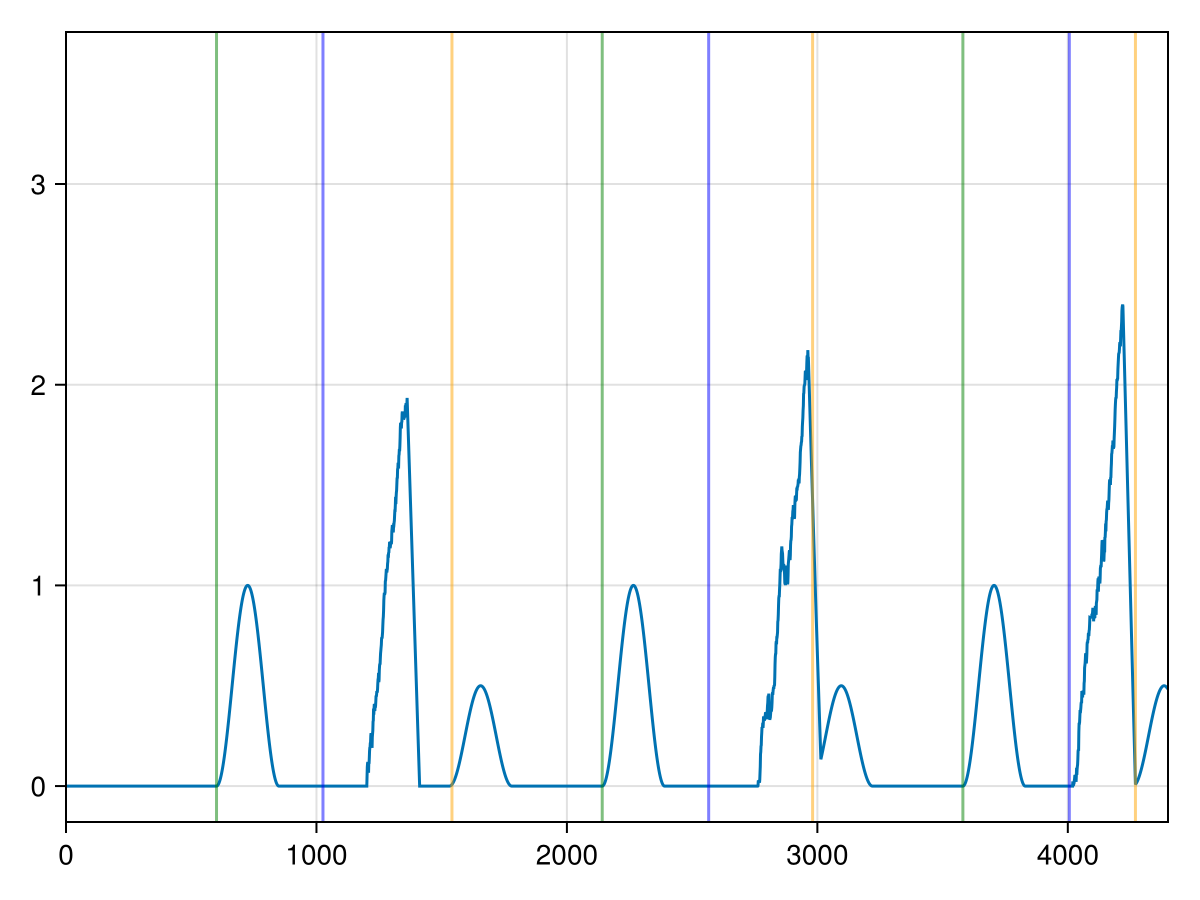

In [24]:
lines(data)
vlines!(evts.latency[evts.event.=='S'], color = (:green, 0.5))
vlines!(evts.latency[evts.event.=='C'], color = (:blue, 0.5))
vlines!(evts.latency[evts.event.=='R'], color = (:orange, 0.5))
CairoMakie.xlims!(0, 4400)
current_figure()

(isnothing(evts), isnothing(tbl)) = (false, false)


┌ Warning: Missings in data - we remove any trial from data and designmatrix
└ @ Unfold C:\Users\Zahnbuerste_HQ\.julia\packages\Unfold\5pvbP\src\solver\prepare.jl:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Missings in data - we remove any trial from data and designmatrix
└ @ Unfold C:\Users\Zahnbuerste_HQ\.julia\packages\Unfold\5pvbP\src\solver\prepare.jl:19
┌ Warning: Missings in data - we remove any trial from data and designmatrix
└ @ Unfold C:\Users\Zahnbuerste_HQ\.julia\packages\Unfold\5pvbP\src\solver\prepare.jl:19


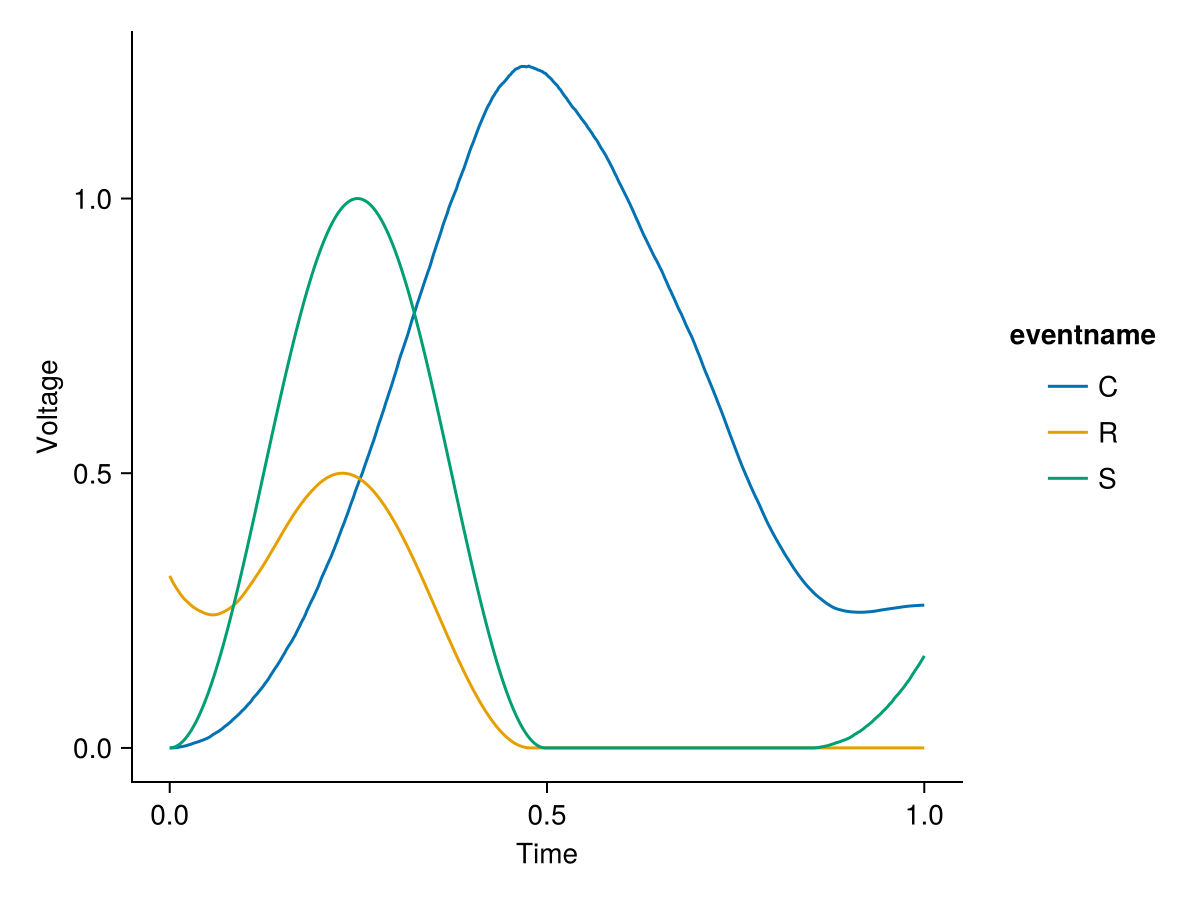

In [25]:
evts2 =deepcopy(evts)
evts2.event = string.(evts2.event)
data_epochs, times_epoch = Unfold.epoch(data = data, tbl = evts2, τ = (0, 1.0), sfreq = fs);
f = @formula(0 ~ 1)# note the formulas left side is `0 ~ ` for technical reasons`
#m = fit(UnfoldModel, f, evts, data_epochs, times_epoch);
m = fit(UnfoldModel, ["S"=>(f,times_epoch),"R"=>(f,times_epoch),"C"=>(f,times_epoch)], evts2, data_epochs);
results = coeftable(m)
plot_erp(results;mapping=(;color=:eventname))

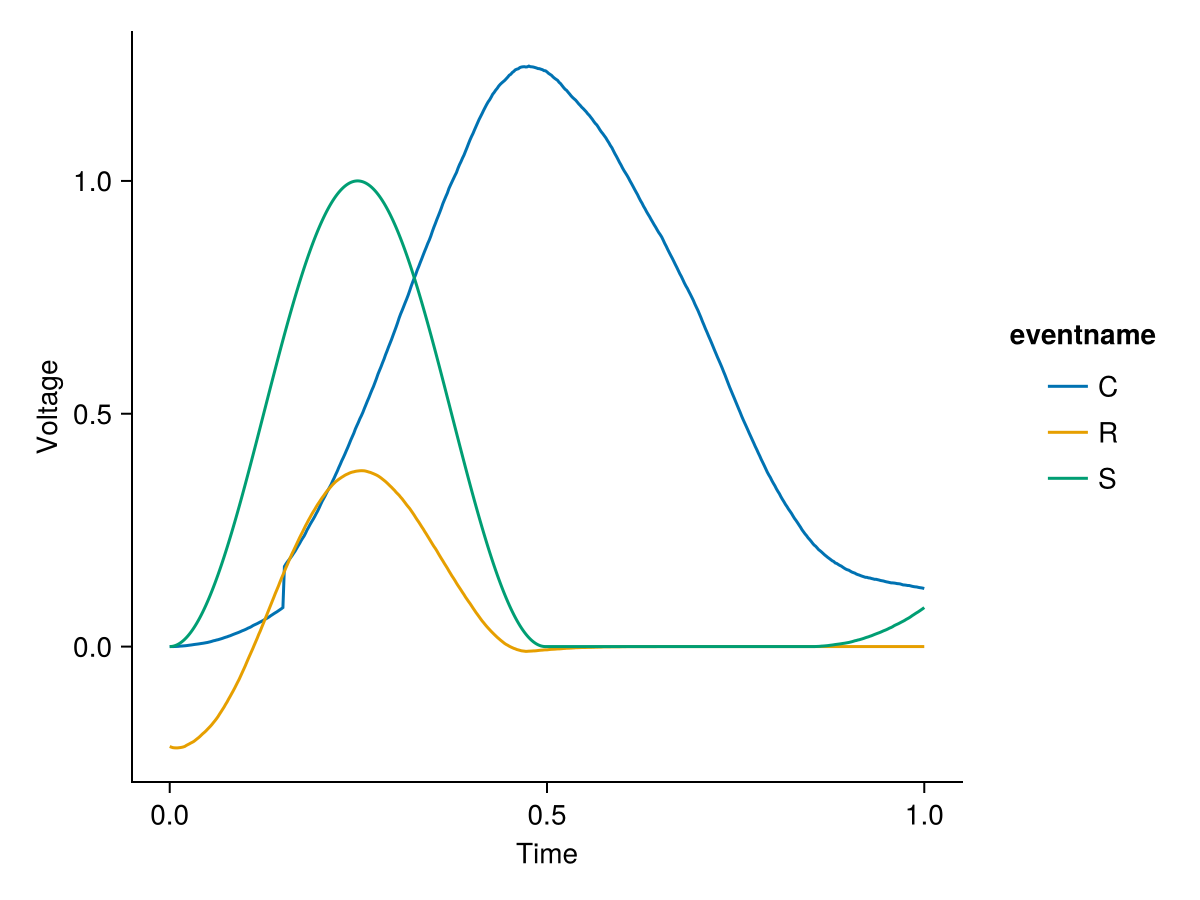

In [26]:
f = @formula 0 ~ 1# note the formulas left side is `0 ~ ` for technical reasons`
#m = fit(UnfoldModel, f, evts, data_epochs, times_epoch);
fir = firbasis(τ=(0,1.0),sfreq=fs)
evts2 =deepcopy(evts)
evts2.event = string.(evts2.event)
m = fit(UnfoldModel, ["S"=>(f,fir),"R"=>(f,firbasis(τ=(0,1.0),sfreq=fs)),"C"=>(f,firbasis(τ=(0,1.0),sfreq=fs))], evts2, data);
results = coeftable(m)
plot_erp(results;mapping=(;color=:eventname))